# Homework 7

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence except for 2 of the entries, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet that generates a sequence and its target for the addition problem.

Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalizes scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:
      1. This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
      2. The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
      3. If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.
2. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

**Question 1**

In [31]:
# Function to generate a sequence, and a function to generate batches of sequences

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

def generate_batch(n_samples, T, input_dim):
    X = np.zeros([n_samples,T,input_dim])
    Y = np.zeros([n_samples])
    
    for i in range(n_samples):
        temp = addition_problem(T)
        X[i] = temp[0]
        Y[i] = temp[1]
    X = torch.from_numpy(X).to(torch.float32)
    Y = torch.from_numpy(Y).to(torch.float32)

    return X, Y

In [32]:
# Define the model

class AttentionPoolingModel(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(AttentionPoolingModel, self).__init__()

    # Encoding Layer
    self.fc1 = nn.Linear(input_size, hidden_size)

    # Attention Pooling
    self.Wa = nn.Linear(hidden_size, hidden_size)
    self.q = nn.Linear(hidden_size, 1, bias=False)

    # Decoding Layers  
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.decoder = nn.Linear(hidden_size,1)

    # Activation Functions
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()


  def forward(self, x):

    # Encode the inputs
    h = self.relu(self.fc1(x))

    # Generate attention scores
    x1 = self.tanh(self.Wa(h))
    x2 = self.q(x1)
    x3 = torch.softmax(x2, dim=1)

    # Dot product of state and attention scores to generate context
    ctxt = torch.matmul(x3.transpose(1, 2), h)

    # Decode the context
    l2 = self.relu(self.fc2(ctxt))
    output = self.decoder(ctxt)
    
    return output

In [33]:
# Hyperparameters
lr = 0.001
hidden_size = 100
input_dim = 2
epochs = 500
T = 50
n_samples = 100

# Construct the model
model = AttentionPoolingModel(input_dim, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Final Loss:  0.00018251483561471105


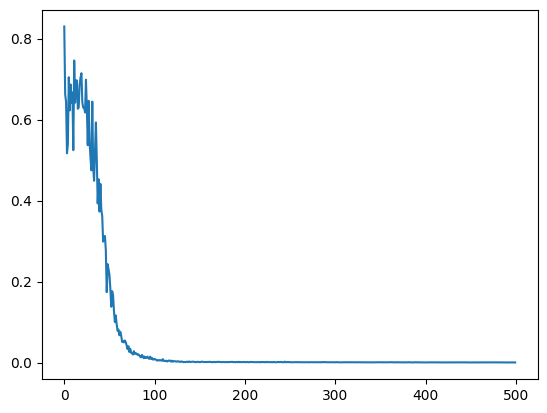

In [34]:
# Train the model with a sequence size of 50
# Print the final loss and plot the loss over epochs
def train(n_samples, input_dim, epochs):
    loss_hist = []
    
    for epoch in range(epochs):
        batch = generate_batch(n_samples, T, input_dim)
        X = batch[0]
        Y = batch[1]
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, Y.view(-1,1,1))  
        
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.item())

    plt.plot(loss_hist)
    print("Final Loss: ", loss_hist[-1])
    return(loss_hist[-1])

final_loss = train(n_samples, input_dim, epochs)

Training the model for 1,000 epochs with a new batch of 100 sample sequences each time, we quickly converge to a model with near 0 loss. For a sequence length of 50, after training, the final model loss is 3e-5.

**Question 2**

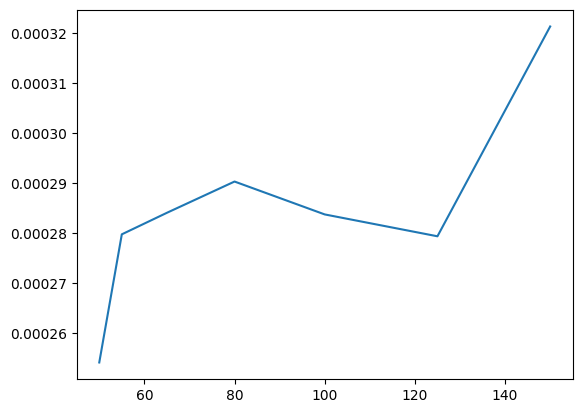

In [35]:
# Plot the model's performance on longer sequence lengths
# Average the error over 100 sequences of the given length

sequence_lengths = [50, 55, 65, 80, 100, 125, 150]
avg_final_training_loss = []

for t in sequence_lengths:
    batch = generate_batch(n_samples, t, input_dim)
    X = batch[0]
    Y = batch[1]
    output = model(X)
    loss = criterion(output, Y.view(-1,1,1))
    avg_final_training_loss.append(loss.item())

plt.plot(sequence_lengths, avg_final_training_loss)

When using the sequence lengths [50, 55, 65, 80, 100, 125, 150], it looks as if model performance gets worse (error increases) when the sequence length increases, but it is hard to conclude that with certainty, as the MSE remains very low for all the above sequence lengths.

I also experimented with the longer sequences to come to a stronger conclusion, including sequences of the following length: T = [50, 55, 65, 80, 100, 125, 150, 300, 500, 100, 1500, 2000, 3000, 5000].

When this experiment it is easy to see that as the sequence length increases, model error increases (performance decreases). However, even with a sequence length of 5,000 the MSE remains below 0.05.

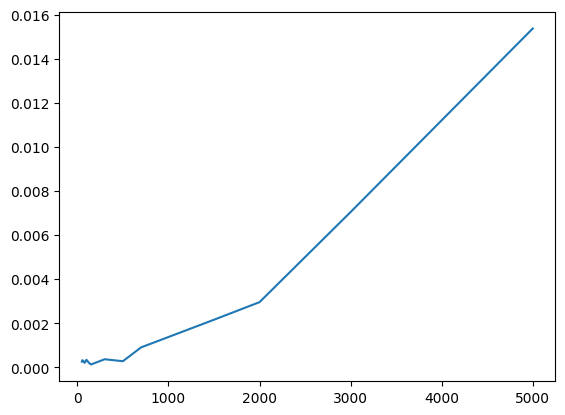

In [36]:
sequence_lengths = [50, 55, 65, 80, 100, 125, 150, 300, 500, 700, 1500, 2000, 3000, 5000]
avg_final_training_loss_b = []

for t in sequence_lengths:
    batch = generate_batch(n_samples, t, input_dim)
    X = batch[0]
    Y = batch[1]
    output = model(X)
    loss = criterion(output, Y.view(-1,1,1))
    avg_final_training_loss_b.append(loss.item())

plt.plot(sequence_lengths, avg_final_training_loss_b)